starting repetition  1 / 2
starting repetition  2 / 2


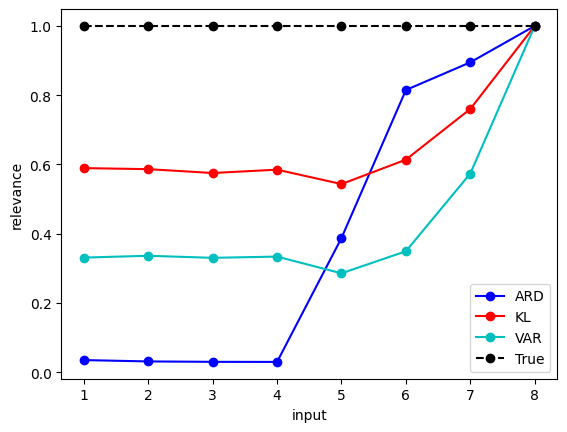

In [14]:
import GPy
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('code')
import function as varsel

np.random.seed(1)



# number of repetitions to average over
repeats = 2
# number of covariates
m = 8
# number of data points
n = 300
# Delta for KL method
delta = 0.0001
# number of quadrature points for VAR method
nquadr = 11

# if x are uniformly distributed
# compute the analytical scaling coefficients for the m components
phi = np.pi*np.linspace(0.1,1,m);
Aunif = np.zeros(m)
for i in range(0,m):
    Aunif[i] = np.sqrt( 4/(2 -1/phi[i]*np.sin(2*phi[i])) )

# if x are normally distributed
# compute the scaling coefficients for the m components
nquadr2 = 11
[points,weights] = np.polynomial.hermite.hermgauss(nquadr2)
std = 0.4
Anor = np.zeros(m)
for i in range(0, m):
    coeff = np.sin(phi[i]*np.sqrt(2)*std*points)*np.sin(phi[i]*np.sqrt(2)*std*points)
    var = 1.0/np.sqrt(np.pi)*np.dot(coeff.T,weights)
    Anor[i] = 1/np.sqrt(var)


rel_ARD = np.zeros(m)
rel_KL = np.zeros(m)
rel_VAR = np.zeros(m)
for i in range(0, repeats):
    x = np.random.uniform(-1.,1.,(n,m))
    #x = np.random.normal(0.0,std,(n,m))
    print('starting repetition ', i + 1,'/',repeats)
    phi = np.tile(np.linspace(np.pi/10,np.pi,m),(n,1))
    xphi = np.multiply(x[:,0:m],phi)
    f = np.sin(xphi)
    for j in range(0,m):
        f[:,j] = f[:,j]*Aunif[j]    
        #f[:,j] = f[:,j]*Anor[j]
    
    # y is a sum of the m components plus Gaussian noise
    yval = f.sum(axis=1) + np.random.normal(0,0.3,(n,))
    y = np.asmatrix(yval).T
    
    # RBF kernel plus constant term
    kernel = GPy.kern.RBF(input_dim=m,ARD=True) + GPy.kern.Bias(input_dim=m)
    model = GPy.models.GPRegression(x,y,kernel)
    model.optimize()
    
    # ARD relevance value is the inverse of the length scale
    rel_ARD = rel_ARD + 1/model.sum.rbf.lengthscale
    
    # KL relevance value
    rel_KL = rel_KL + varsel.KLrel(x,model,delta)
    
    # VAR relevance value
    rel_VAR = rel_VAR + varsel.VARrel(x,model,nquadr)
    
 
# normalize the relevance values      
rel_ARD_nor = rel_ARD/np.max(rel_ARD)
rel_KL_nor = rel_KL/np.max(rel_KL)
rel_VAR_nor = rel_VAR/np.max(rel_VAR)

# True relevance, the covariates are equally relevant in the L2 sense
rel_true = np.ones(m)

# plot
covariates = np.arange(1,m+1) 
fig2 = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(covariates,rel_ARD_nor,'-ob',label='ARD')
ax2.plot(covariates,rel_KL_nor,'-or',label='KL')
ax2.plot(covariates,rel_VAR_nor,'-oc',label='VAR')
ax2.plot(covariates,rel_true,'--ok',label='True')
ax2.legend()
ax2.set_ylabel('relevance')
ax2.set_xlabel('input')
plt.show()

In [15]:
from bayesian_optimization import BayesianOptimization
from botorch.test_functions import Levy 

N_INITIAL = 100
EPOCHS = 10
BATCH_SIZE = 10
DIM = 2
LOWER = -10
UPPER = 10

optimizer = BayesianOptimization(fun=Levy(dim=DIM, negate=True), 
                                     batch_size=BATCH_SIZE, 
                                     dim=DIM, 
                                     epochs=EPOCHS, 
                                     n_init=N_INITIAL, 
                                     lower_bound=LOWER,
                                     upper_bound=UPPER,
                                     seed=1,  
                                     acqf_type='qUCB')

x_max, y_max, lengthscales = optimizer.run()
data = optimizer.get_data()
display(data)

Lengthscales of the kernel:  [0.12165734 1.45939665]


tensor([[-4.6455e+00, -2.7649e+00, -5.5725e+00],
        [ 6.8688e+00,  9.8362e+00, -2.0967e+01],
        [ 2.9985e+00, -7.4500e+00, -8.3259e+00],
        [-5.8583e+00,  1.4618e-01, -3.0022e+01],
        [-7.6414e+00, -7.6237e+00, -2.3333e+01],
        [ 1.0408e+00,  4.9287e+00, -9.7862e-01],
        [ 9.7536e+00, -2.3185e+00, -5.4188e+01],
        [-1.2712e+00,  5.2485e+00, -4.1758e+00],
        [-3.1468e-01, -6.0771e+00, -7.0613e+00],
        [ 8.1722e+00,  1.5071e+00, -7.3836e+00],
        [ 1.9583e+00, -3.9018e+00, -4.0478e+00],
        [-9.1837e+00,  8.7067e+00, -3.9773e+01],
        [-7.4018e+00, -1.1890e+00, -2.2469e+01],
        [ 3.9172e+00,  6.3853e+00, -4.2533e+00],
        [ 5.2862e+00, -8.9844e+00, -1.7594e+01],
        [-3.6878e+00,  3.5556e+00, -4.9906e+00],
        [-2.6064e+00, -9.5472e+00, -1.9433e+01],
        [ 6.0746e+00,  2.8684e+00, -1.7318e+01],
        [ 4.7105e+00, -4.7242e-01, -5.3128e+00],
        [-6.3155e+00,  6.9187e+00, -3.9243e+01],
        [-9.6795e+00

In [18]:
x=data[:,:2].numpy()
y=data[:,-1:].numpy()

print(x)
print(y)

[[-4.64549065 -2.76490927]
 [ 6.86879873  9.83616471]
 [ 2.99854875 -7.45000124]
 [-5.85825324  0.14618278]
 [-7.6413931  -7.62368083]
 [ 1.04084849  4.92872   ]
 [ 9.75362301 -2.31853604]
 [-1.27116442  5.2485013 ]
 [-0.31468093 -6.07705653]
 [ 8.1722486   1.50708079]
 [ 1.9582653  -3.90180111]
 [-9.18371007  8.70674253]
 [-7.40178615 -1.1889714 ]
 [ 3.91719103  6.38525009]
 [ 5.28619885 -8.98441635]
 [-3.68779123  3.55561256]
 [-2.60641992 -9.54717532]
 [ 6.0746026   2.86835432]
 [ 4.71047759 -0.47242284]
 [-6.31553233  6.91868067]
 [-9.67948738 -4.43524122]
 [ 1.83358312  7.9902041 ]
 [ 8.0426836  -5.38978785]
 [-0.81534088  2.0698297 ]
 [-2.35772491 -1.60932243]
 [ 8.96003366  5.7892704 ]
 [ 0.25214195 -8.17422241]
 [-8.72307032  4.22924042]
 [-5.35789937 -6.75053179]
 [ 3.12781096  0.69673419]
 [ 6.99317813 -3.30566823]
 [-4.15001988  9.12694097]
 [-3.81371975 -6.89000398]
 [ 7.21106768  0.52307248]
 [ 3.57641339 -2.81526268]
 [-5.10582805  9.57341075]
 [-8.3135283  -2.08996236]
 

In [22]:
m=2
delta = 0.0001
# number of quadrature points for VAR method
nquadr = 11

kernel = GPy.kern.RBF(input_dim=m,ARD=True) + GPy.kern.Bias(input_dim=m)
model = GPy.models.GPRegression(x,y,kernel)
model.optimize()

rel_ARD = np.zeros(m)
rel_KL = np.zeros(m)
rel_VAR = np.zeros(m)
# ARD relevance value is the inverse of the length scale
rel_ARD = rel_ARD + 1/model.sum.rbf.lengthscale
    
# KL relevance value
rel_KL = rel_KL + varsel.KLrel(x,model,delta)
    
# VAR relevance value
rel_VAR = rel_VAR + varsel.VARrel(x,model,nquadr)

print(rel_KL)
print(rel_VAR)

[7.87227345 0.65298685]
[314.69811544  15.03220597]


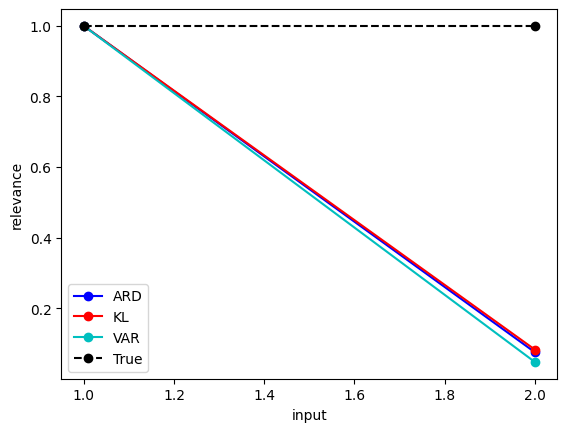

In [21]:
# normalize the relevance values      
rel_ARD_nor = rel_ARD/np.max(rel_ARD)
rel_KL_nor = rel_KL/np.max(rel_KL)
rel_VAR_nor = rel_VAR/np.max(rel_VAR)

# True relevance, the covariates are equally relevant in the L2 sense
rel_true = np.ones(m)

# plot
covariates = np.arange(1,m+1) 
fig2 = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(covariates,rel_ARD_nor,'-ob',label='ARD')
ax2.plot(covariates,rel_KL_nor,'-or',label='KL')
ax2.plot(covariates,rel_VAR_nor,'-oc',label='VAR')
ax2.plot(covariates,rel_true,'--ok',label='True')
ax2.legend()
ax2.set_ylabel('relevance')
ax2.set_xlabel('input')
plt.show()